In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
import re

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
start_year = 1993
curr_year = datetime.now().year

In [2]:
# Custom API
from sys import path

path.append('../API/eda')
from data_visualizations import get_yearly_base_rates, get_seed_pairs, format_plot

path.append('../API/fetch')
import data_fetch as fetch

path.append('../API/model')
from model_selection import get_cv_models
from model_evaluation import evaluate_cv_models, get_classification_report

path.append('../API/preprocess')
from data_clean import clean_basic_stats
from data_pipeline import dataset_pipeline, feature_pipeline, bracket_pipeline

# Data Fetching

## Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
<br>**Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won**

<br>And lastly, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (0-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?**

## Examples

### Team Regular Season Stats

In [3]:
basic_stats_df = fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-school-stats.html",
                                     attrs={'id': 'basic_school_stats'})
basic_stats_df.head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,409,584,.700,NaN,965,285,178,109,385,546
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,320,493,.649,NaN,795,315,163,47,352,573
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,456,650,.702,NaN,1273,501,246,135,498,650
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,541,767,.705,NaN,1049,395,194,42,556,567
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,458,702,.652,NaN,1117,337,185,120,487,539


In [4]:
adv_stats_df = fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-advanced-school-stats.html", 
                                   attrs={'id': 'adv_school_stats'})
adv_stats_df.head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,.279,.500,49.9,44.3,NaN,9.6,.458,17.4,NaN,.263
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,.277,.517,51.1,54.3,NaN,5.5,.488,18.4,NaN,.241
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,.270,.527,52.2,56.4,NaN,9.6,.494,17.8,NaN,.228
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,.203,.557,51.3,46.4,NaN,2.8,.518,20.7,NaN,.305
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,.299,.541,51.7,43.1,NaN,8.9,.513,19.4,NaN,.271


### Team Rankings

In [5]:
rankings_df = fetch.get_rankings_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-ratings.html")
rankings_df.head()

,Team,Top_25
2,North Carolina,1
3,Kentucky,1
4,Duke,1
5,Indiana,1
6,Cincinnati,1


### Coach Tournament Performance

In [6]:
coaches_df = fetch.get_coach_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-coaches.html")
coaches_df.head()

,Coach_Team,MM,S16,F4,Champs
2,Air Force,,,,
3,Akron,,,,
4,Alabama,,,,
5,Alabama-Birmingham,11,5,2,
6,Alabama State,,,,


### Tournament Game Data

In [7]:
hist_bracket_df = fetch.get_hist_bracket(url=f'https://www.sports-reference.com/cbb/postseason/{start_year}-ncaa.html', 
                                         year=start_year)
hist_bracket_df.head()

,Year,Round,Seed,Team,Score,Seed.1,Team.1,Score.1
0,1993,First Round,1,UNC,85,16,East Carolina,65
1,1993,First Round,8,Rhode Island,74,9,Purdue,68
2,1993,First Round,5,St. John's (NY),85,12,Texas Tech,67
3,1993,First Round,4,Arkansas,94,13,Holy Cross,64
4,1993,First Round,6,Virginia,78,11,Manhattan,66


# Data Pipeline

Below is the output of a merge of the datasets displayed above (after they've been cleaned). Once we remove the features with nulls that won't be imputed, we can begin our exploratory data analysis (EDA).

In [8]:
# Check if the historical data CSV exists, if it doesn't then create it
try:
    mm_matchups_df = pd.read_csv(f'{curr_year}_march_madness_hist_data.csv')
except FileNotFoundError:
    mm_matchups_df = dataset_pipeline(np.arange(start_year, curr_year - 1))
    mm_matchups_df.to_csv(f'{curr_year}_march_madness_hist_data.csv', index=False)

mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,G_Favorite,W-L%_Favorite,SOS_Favorite,...,BLK%_Underdog,eFG%_Underdog,TOV%_Underdog,ORB%_Underdog,FT/FGA_Underdog,Top_25_Underdog,MM_Underdog,S16_Underdog,F4_Underdog,Champs_Underdog
0,1993,First Round,1,UNC,16,East Carolina,0,38.0,0.895,11.25,...,5.9,0.465,17.3,NaN,0.248,0.0,1.0,0.0,0.0,0.0
1,1993,Second Round,1,UNC,8,Rhode Island,1,38.0,0.895,11.25,...,6.9,0.484,16.4,NaN,0.324,0.0,1.0,0.0,0.0,0.0
2,1993,Sweet Sixteen,1,UNC,4,Arkansas,0,38.0,0.895,11.25,...,7.2,0.539,15.9,NaN,0.243,1.0,9.0,3.0,1.0,0.0
3,1993,Elite Eight,1,UNC,2,Cincinnati,0,38.0,0.895,11.25,...,7.3,0.512,16.9,NaN,0.222,1.0,3.0,2.0,1.0,0.0
4,1993,Final Four,1,UNC,2,Kansas,0,38.0,0.895,11.25,...,6.5,0.565,17.0,NaN,0.280,1.0,4.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2019,First Round,3,Purdue,14,Old Dominion,0,36.0,0.722,11.99,...,14.3,0.471,15.0,31.8,0.192,0.0,8.0,2.0,0.0,0.0
1743,2019,Second Round,3,Purdue,6,Villanova,0,36.0,0.722,11.99,...,8.7,0.532,14.2,30.1,0.251,0.0,16.0,6.0,3.0,2.0
1744,2019,First Round,7,Cincinnati,10,Iowa,1,35.0,0.800,5.50,...,9.0,0.527,15.1,29.5,0.313,0.0,9.0,0.0,0.0,0.0
1745,2019,Second Round,2,Tennessee,10,Iowa,0,37.0,0.838,10.16,...,9.0,0.527,15.1,29.5,0.313,0.0,9.0,0.0,0.0,0.0


## Handling Missing Values

### Finding the Nulls

Recall that our cleaned dataset has a total of 1,747 March Madness games present, and each March Madness will consist of no more than 67 games (4 play-in games + 63 tournament games). As can be seen below, the advanced stats pertaining to personal fouls (PF) and turnovers (TOV) are the only features listed with no more than a season's worth of missing data. Given how rapidly the gameplay of college basketball has evolved over the time horizon of our dataset, imputing nulls on multiple years of March Madness data would likely be a futile effort. The features with a high volume of nulls (1> season) will be dropped from the dataset.

In [9]:
# Given that a feature has any nulls, find the number of nulls present
true_nulls = fetch.get_feature_null_counts(mm_matchups_df)
true_nulls

Pace_Underdog    1072
Pace_Favorite    1065
ORB%_Favorite     766
STL%_Favorite     766
ORtg_Favorite     766
STL%_Underdog     765
ORtg_Underdog     765
ORB%_Underdog     764
ORB_Underdog      255
ORB_Favorite      254
PF_Favorite        64
PF_Underdog        64
TOV%_Underdog       3
TOV_Underdog        3
TOV_Favorite        1
TOV%_Favorite       1
dtype: int64

In [10]:
# Get turnover features from true_nulls
tov_null_fills = [col for col in true_nulls.index if ('TOV' in col)]

# Get personal foul features from true_nulls
pf_null_fills = [col for col in true_nulls.index if ('PF' in col)]

# All other features found in true_nulls are dropped from our original dataset
null_drops = list(set(true_nulls.index) - set(tov_null_fills) - set(pf_null_fills))
mm_matchups_df.drop(null_drops, axis=1, inplace=True)

In [11]:
# View the rows containing all of the dataset's nulls to be imputed
# This will be a useful reference to validate the proper imputation of the nulls
tov_nulls_rows = fetch.get_null_rows(tov_null_fills, mm_matchups_df)
pf_nulls_rows = fetch.get_null_rows(pf_null_fills, mm_matchups_df)

display(tov_nulls_rows), display(pf_nulls_rows)

,Year,TOV%_Underdog,TOV_Underdog,TOV_Favorite,TOV%_Favorite
51,1993,NaN,NaN,561.0,17.4
52,1993,NaN,NaN,373.0,15.9
56,1993,16.6,552.0,NaN,NaN
483,2000,NaN,NaN,520.0,17.8


,Year,PF_Favorite,PF_Underdog
568,2002,NaN,NaN
569,2002,NaN,NaN
570,2002,NaN,NaN
571,2002,NaN,NaN
572,2002,NaN,NaN
...,...,...,...
627,2002,NaN,NaN
628,2002,NaN,NaN
629,2002,NaN,NaN
630,2002,NaN,NaN


(None, None)

### What are the Distributions of the Features We Wish to Impute?

Upon looking at the distributions below of all turnover and personal foul features, we can see that they closely resemble a normal distribution. Given this assumption, the features' means will serve as good values for imputing the nulls.

1993 feature distributions
2000 feature distributions


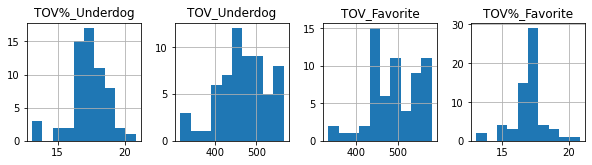

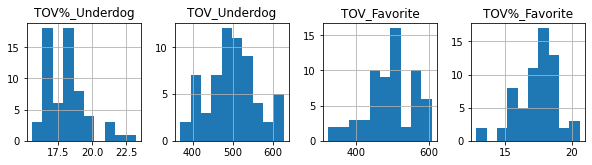

In [12]:
# View the distributions of the dataset's turnover features
tov_null_years = sorted(list(set(tov_nulls_rows['Year'])))

for year in tov_null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[tov_null_fills].hist(figsize=(10, 5), layout=(len(tov_null_years), len(tov_null_fills)))

array([[<AxesSubplot:title={'center':'PF_Favorite'}>,
        <AxesSubplot:title={'center':'PF_Underdog'}>]], dtype=object)

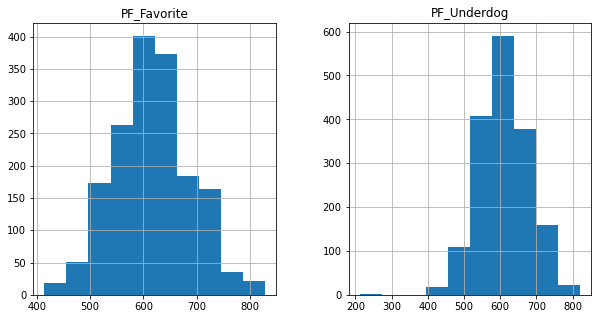

In [13]:
# View the distributions of the dataset's personal foul features
mm_matchups_df[pf_null_fills].hist(figsize=(10, 5), layout=(1, len(pf_null_fills)))

### Impute TOV Nulls by Season

In [14]:
# Retrieve TOV feature means by season; only include seasons that contain nulls
tov_col_means = mm_matchups_df[tov_nulls_rows.columns].groupby('Year').mean()
tov_col_means.loc[tov_null_years]

,TOV%_Underdog,TOV_Underdog,TOV_Favorite,TOV%_Favorite
Year,,,,
1993,17.280328,466.426230,492.629032,17.066129
2000,18.106452,498.016129,496.650794,17.384127


In [15]:
for year in tov_null_years:
    for col in tov_null_fills:
        # Get feature's rows with nulls for given year
        col_fill_rows = tov_nulls_rows[tov_nulls_rows['Year'] == year].index
        # Get feature's mean for given year
        col_year_mean = np.round(tov_col_means.loc[year, col], 1)
        # Impute nulls of interest
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)

# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[tov_nulls_rows.index, tov_null_fills]

,TOV%_Underdog,TOV_Underdog,TOV_Favorite,TOV%_Favorite
51,17.3,466.4,561.0,17.4
52,17.3,466.4,373.0,15.9
56,16.6,552.0,492.6,17.1
483,18.1,498.0,520.0,17.8


### Impute PF Nulls Using Entire Distribution

In [16]:
# Retrieve PF feature means; only found in one season
pf_col_means = mm_matchups_df[pf_null_fills].mean()
pf_col_means

PF_Favorite    616.112299
PF_Underdog    610.071301
dtype: float64

In [17]:
for col in pf_null_fills:
    # Get feature's mean
    col_mean = np.round(mm_matchups_df[col].mean(), 1)
    # Impute nulls of interest
    mm_matchups_df[col].fillna(col_mean, inplace=True)
    
# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[pf_nulls_rows.index, pf_null_fills]

,PF_Favorite,PF_Underdog
568,616.1,610.1
569,616.1,610.1
570,616.1,610.1
571,616.1,610.1
572,616.1,610.1
...,...,...
627,616.1,610.1
628,616.1,610.1
629,616.1,610.1
630,616.1,610.1


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA:
 - What is our bracket's accuracy if we guess the favorite always wins?
 - How often do upsets occur in a given year's March Madness?
 - What is the distribution of upsets across the tournament rounds?
 - Which seeding combinations are most likely to produce upsets?

## What is our Bracket's Accuracy if We Guess the Favorite Always Wins?

This is a strategy many of us have employed at least once while filling out a March Madness bracket, myself included. This is a classic EDA question which explores the idea of the base rate: historically, how often would we be right if we always assumed the favorite won the March Madness matchup? ~68.6% of our predictions would be correct according to our data, approximately 2 out of every 3 games. This means that for any model to be of value to us, it must demonstrate >68.6% of its predictions are correct.

In college basketball, the best (and thus most impactful) players typically leave the NCAA after no more than 2 years. Thus, a 2-year moving average was chosen to illustrate the base rate's trends as new impactful players participate in March Madness. Our base rate is maintained fairly consistently over time, with a few exceptions scattered across the dataset's time horizon.

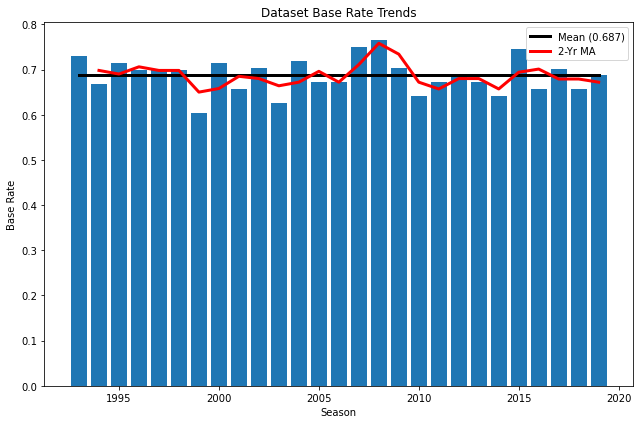

In [18]:
# Each season's base rate
yearly_base_rates = get_yearly_base_rates(mm_matchups_df)
# Dataset's mean base rate
mean_base_rate = np.round(yearly_base_rates.mean(), 3)
# Moving average
years_ma = 2
base_rate_ma = np.round(yearly_base_rates.rolling(years_ma).mean(), 3)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_base_rates.index, [mean_base_rate] * len(yearly_base_rates), color='k', linewidth=3, label=f'Mean ({mean_base_rate})')
plt.plot(yearly_base_rates.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rates.index, yearly_base_rates)

format_plot(title='Dataset Base Rate Trends', xlabel='Season', ylabel='Base Rate')

## How Often Do Upsets Occur in a Given Year's March Madness?

If favorites win March Madness matchups ~68.6% of the time, then we can conclude the underdogs are winning the other 31.4%; this translates to approximately 20 upsets per year. This knowledge gives us insight into how many upsets we should expect our model to predict (i.e. 25 is likely too high, 15 is likely too low).

A 2-year moving average has been employed once again to highlight the trends present across the dataset's time horizon. At first it may appear to be more volatile than the base rate trends, but this is simply due to the scale of the y-axis.

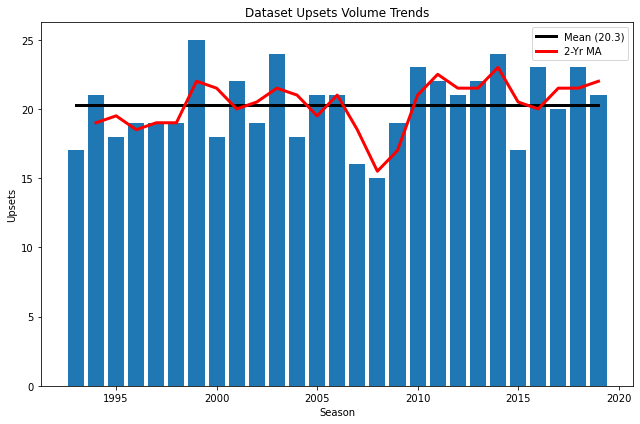

In [19]:
# Each season's upset count
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': 'sum'})
# Dataset's mean upset count
mean_upsets = np.round(yearly_upsets['Underdog_Upset'].mean(), 1)
# Moving average
upsets_ma = np.round(yearly_upsets.rolling(years_ma).mean(), 1)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_upsets.index, [mean_upsets] * len(yearly_upsets), color='k', linewidth=3, label=f'Mean ({mean_upsets})')
plt.plot(yearly_upsets.index, upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_upsets.index, yearly_upsets['Underdog_Upset'])

format_plot(title='Dataset Upsets Volume Trends', xlabel='Season', ylabel='Upsets')

## What is the Distribution of Upsets Across the Tournament Rounds?

Of the 20 upsets that we can expect in any given March Madness, the visualization below gives us an idea of how many upsets we can expect in each round. Nearly 70% of all upsets happen in the first 2 rounds, which is sensible given that 75% of all games are held in the first 2 rounds. Fewer upsets in each successive round is expected not only because of a diminished volume of games, but also a greater saturation of top-tier teams amongst the remaining teams in contention. We should expect our model to follow a similar pattern.

In [20]:
# Retrieve data about March Madness matchup seed pairings
seed_pairs = get_seed_pairs(mm_matchups_df)
# Extract seed pairs that resulted in upsets
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]

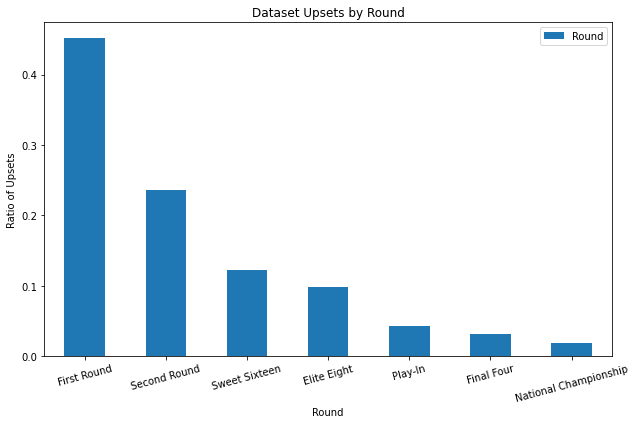

In [21]:
# Group upset seed pairs by round and count them
upset_rounds_freq = upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Dataset Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

## Which Seeding Combinations are the Most Likely to Produce Upsets?

Suppose our model predicts 12 upsets in the first round, even though we should only expect 9 according to our EDA. In the event this type of situation arises, it'd be valuable to know which seed pairings are most likely to produce upsets so we could discard 3 of the 12 first round upsets with the lowest upset likelihoods.

Only the top 25 upset likelihoods are shown because our EDA also revealed we should expect no more than 25 upsets in a given year. We can see once again that the overwhelming majority of upsets occur in the first round, particularly in the 4 seed pairings that are the most evenly matched (Seeds 8 vs. 9 through Seeds 5 vs. 12). Our model should emulate this behavior fairly closely in its upset predictions.

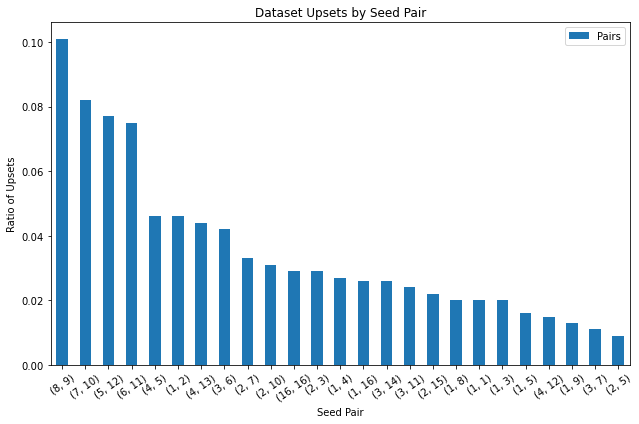

In [22]:
# Group upsets by seed pairing and count them
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

# Plot findings
upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Dataset Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

# Feature Engineering & Analysis

Below we can see our original feature matrix (X) and then our feature matrix prepped for model fitting (prep_all_X). This transformation is performed by passing X through the feature pipeline. 

One of the primary actions that transpires in the pipeline is subtracting the favorites' stats from the underdogs' stats in each matchups to create underdog relative features. This not only retains virtually all of our information, but also improves computation speed and reduces the likelihood of overfitting.

The second primary action is the scaling of our numerical features. This conversion of all numerical features to a normal distribution is important because it nullifies the possibility of features' number ranges being a deciding factor in a model's  learning process.

Should you be curious about the more intricate details, you may refer to the feature_pipeline() custom API documentation.

In [23]:
# Drop unneeded features
mm_matchups_df.drop(['Year', 'Team_Favorite', 'Team_Underdog'], axis=1, inplace=True)
# Store rounds data (for EDA visualizations)
all_rounds = mm_matchups_df['Round']

# Create feature matrix and target variable
X = mm_matchups_df.drop('Underdog_Upset', axis=1)
y = mm_matchups_df['Underdog_Upset']

display(X), display(y)

,Round,Seed_Favorite,Seed_Underdog,G_Favorite,W-L%_Favorite,SOS_Favorite,Tm._Favorite,Opp._Favorite,FG_Favorite,FG%_Favorite,...,AST%_Underdog,BLK%_Underdog,eFG%_Underdog,TOV%_Underdog,FT/FGA_Underdog,Top_25_Underdog,MM_Underdog,S16_Underdog,F4_Underdog,Champs_Underdog
0,First Round,1,16,38.0,0.895,11.25,3272.0,2596.0,1219.0,0.506,...,47.7,5.9,0.465,17.3,0.248,0.0,1.0,0.0,0.0,0.0
1,Second Round,1,8,38.0,0.895,11.25,3272.0,2596.0,1219.0,0.506,...,50.7,6.9,0.484,16.4,0.324,0.0,1.0,0.0,0.0,0.0
2,Sweet Sixteen,1,4,38.0,0.895,11.25,3272.0,2596.0,1219.0,0.506,...,58.5,7.2,0.539,15.9,0.243,1.0,9.0,3.0,1.0,0.0
3,Elite Eight,1,2,38.0,0.895,11.25,3272.0,2596.0,1219.0,0.506,...,57.0,7.3,0.512,16.9,0.222,1.0,3.0,2.0,1.0,0.0
4,Final Four,1,2,38.0,0.895,11.25,3272.0,2596.0,1219.0,0.506,...,61.9,6.5,0.565,17.0,0.280,1.0,4.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,First Round,3,14,36.0,0.722,11.99,2760.0,2421.0,967.0,0.451,...,53.3,14.3,0.471,15.0,0.192,0.0,8.0,2.0,0.0,0.0
1743,Second Round,3,6,36.0,0.722,11.99,2760.0,2421.0,967.0,0.451,...,56.9,8.7,0.532,14.2,0.251,0.0,16.0,6.0,3.0,2.0
1744,First Round,7,10,35.0,0.800,5.50,2510.0,2194.0,872.0,0.432,...,59.3,9.0,0.527,15.1,0.313,0.0,9.0,0.0,0.0,0.0
1745,Second Round,2,10,37.0,0.838,10.16,3035.0,2580.0,1106.0,0.496,...,59.3,9.0,0.527,15.1,0.313,0.0,9.0,0.0,0.0,0.0


0       0
1       1
2       0
3       0
4       0
       ..
1742    0
1743    0
1744    1
1745    0
1746    0
Name: Underdog_Upset, Length: 1747, dtype: int32

(None, None)

In [24]:
# We'll stratify the split of our training & test datasets according to the target variable's 
# distribution so our model can learn the trends observed in our EDA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Drop round data because it's already stored in previous notebook cell
X_train.drop('Round', axis=1, inplace=True)
X_test.drop('Round', axis=1, inplace=True)

# All datasets will be scaled based on fit found for training dataset
fit_df = X_train
basic_stats_cols = clean_basic_stats(basic_stats_df).columns

# Pass datasets through feature pipeline to prep them for model fitting
prep_X_train = feature_pipeline(X_train, fit_df, basic_stats_cols)
prep_X_test = feature_pipeline(X_test, fit_df, basic_stats_cols)

prep_all_X = pd.concat([prep_X_train, prep_X_test])
prep_all_X

,Seed_Favorite,Seed_Underdog,Underdog_Rel_FT/FGA,Underdog_Rel_TRB/Game,Underdog_Rel_TOV/Game,Underdog_Rel_BLK%,Underdog_Rel_eFG%,Underdog_Rel_TS%,Underdog_Rel_FT%,Underdog_Rel_Top_25,...,Underdog_Rel_AST%,Underdog_Rel_3PAr,Underdog_Rel_3P/Game,Underdog_Rel_AST/Game,Underdog_Rel_FT/Game,Underdog_Rel_SOS,Underdog_Rel_3P%,Underdog_Rel_PF/Game,Underdog_Rel_TRB%,Underdog_Rel_MM
1053,-0.960821,-2.007954,0.428327,-0.428371,0.588625,0.037416,0.797197,0.504699,-1.461333,0.893529,...,-0.412656,0.883591,-0.077114,-1.049712,-0.584860,0.480158,-0.817047,0.246949,0.294434,-1.359887
1657,0.760917,0.266666,0.469131,0.172310,-0.120303,0.382700,-0.118365,-0.035327,0.006774,-0.923443,...,0.280715,-0.277115,-0.680176,0.522692,0.692954,0.680743,-1.184594,-1.772841,0.084038,-1.027063
1740,2.827002,0.772137,-0.040921,1.765420,0.021483,-0.706272,0.159078,0.084679,-0.310654,0.893529,...,-0.427101,-1.069126,-0.515705,0.240465,0.279544,-0.664160,0.338098,0.088534,1.466643,-0.805180
407,1.105265,0.013930,-1.407860,-0.428371,-2.199825,0.010856,-0.201598,-0.035327,2.010542,0.893529,...,-1.163808,0.910902,0.635595,-0.928758,-1.374098,-0.189005,-0.160715,0.365760,0.324491,0.526118
436,0.072222,0.772137,3.141802,0.955806,1.911957,-0.334428,0.297799,1.224735,2.526363,0.893529,...,-0.080416,-0.509256,-0.406057,0.119511,3.699575,-1.066974,0.285592,2.108324,1.075907,-0.916121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,4.204393,1.530344,1.162801,-0.297789,0.966720,-0.653151,0.492009,0.654707,-0.092422,0.893529,...,-0.210423,1.252286,1.183834,0.119511,1.444609,0.876395,0.154325,1.039024,-0.847717,0.526118
1534,-0.960821,-0.238805,0.979183,1.373672,0.305054,-0.068825,-0.340319,-0.215336,-0.350333,0.893529,...,-0.773786,0.173512,0.635595,0.079193,1.820437,0.134890,-0.108208,1.197439,0.084038,0.082352
62,-0.616473,1.277608,0.203904,-1.838666,-1.585421,-1.184357,-0.895205,-0.695360,0.423399,-0.923443,...,0.800743,1.265942,0.690419,-0.807804,-0.547277,-0.600039,-0.108208,0.286553,-0.937887,-0.916121
989,-0.960821,-2.260689,0.591543,-0.637304,0.257792,-0.440669,0.214566,0.744711,2.407327,0.893529,...,-0.037080,-1.055471,-1.118767,-0.243351,0.204378,1.042453,0.154325,-1.257992,1.015794,0.193294


## What are the Distributions of all our Features?

The illustration below shows us the impact of the feature scaling mentioned earlier. Our features are predominantly normally distributed.

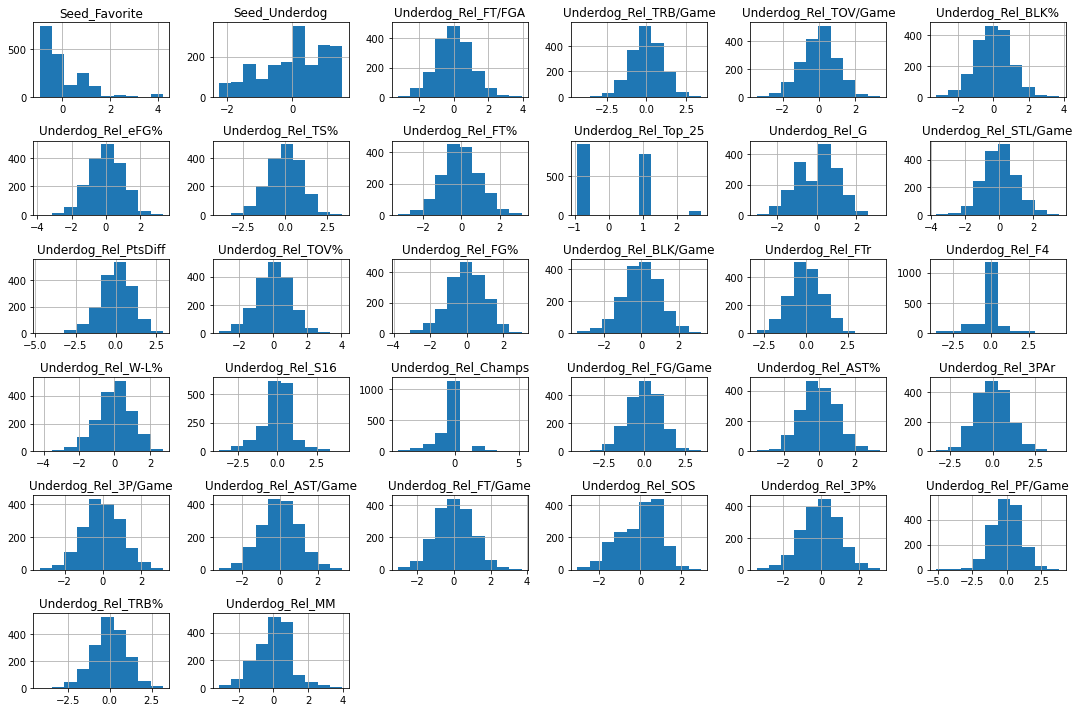

In [25]:
prep_all_X.hist(figsize=(15, 10))
plt.tight_layout()

## What Features have the Greatest Predictive Power?
The plot below represents an important concept in data science & machine learning: normalized information gain. It's a ratio of how much predictive power can be attributed to each feature in a feature matrix; these values should sum to 1, or 100% of the predictive power.

We can see underdog relative games (Underdog_Rel_G) has a staggering lead over the remaining features - almost 25% of predictive power can be attributed to that one feature alone! This is sensible because it highlights how March Madness matchup favorites play more games together than their underdog opponents, which gives them more experience. This strong predictive power may negatively impact our predictions for this 2020-21 season because the COVID-19 pandemic messed up the schedules of many traditionally top-tier teams this year.

The remaining dominant features are equally sensible: strength of schedule (SOS; measures the caliber of their regular season opponents), win-loss % (W-L%; what was their regular season record), and point differential (PtsDiff; what was their average margin of victory/defeat).

No handles with labels found to put in legend.


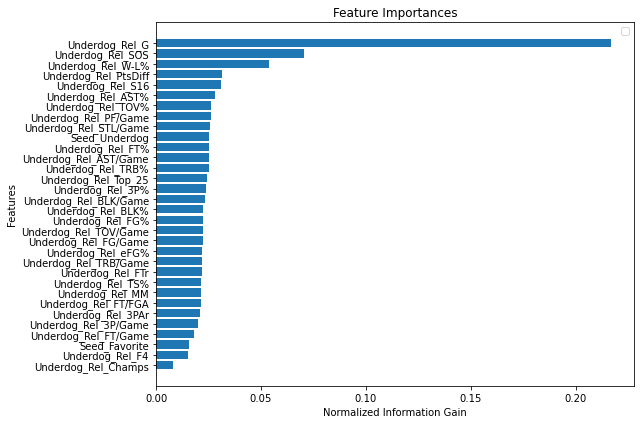

In [26]:
# Fit data to a Random Forest to find feature importances
rf = RandomForestClassifier().fit(prep_X_train, y_train)

# Sort features & their corresponding values in by importance
importances = rf.feature_importances_
feat_importances = prep_all_X.columns[np.argsort(importances)]
feat_values = np.sort(importances)

# Plot findings
plt.figure(figsize=(9, 6))
plt.barh(feat_importances, feat_values)

format_plot(title='Feature Importances', xlabel='Normalized Information Gain', ylabel='Features')

## What are the Correlations Between Features?

Though correlation differs from information gain, we still see the same features dominating the landscape. Even more interesting is that they're dominating to approximately the same degree that they were in our information gain plot above.

No handles with labels found to put in legend.


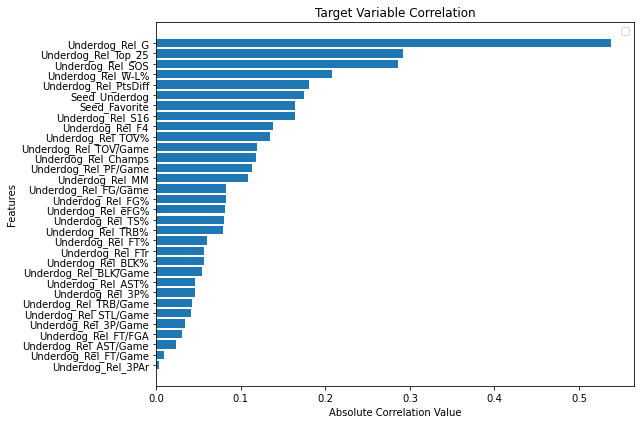

In [27]:
# Get feature matrix's correlations to target variable, then sort by absolute value
prep_X_y = prep_X_train.merge(y_train, left_index=True, right_index=True)
abs_desc_corr = np.abs(prep_X_y.corr().loc['Underdog_Upset']).sort_values()
abs_desc_corr.drop('Underdog_Upset', inplace=True)

# Plot findings
plt.figure(figsize=(9, 6))
plt.barh(abs_desc_corr.index, abs_desc_corr.values)

format_plot(title='Target Variable Correlation', xlabel='Absolute Correlation Value', ylabel='Features')

# Model Selection

1,747 total records in a dataset isn't much, so it was necessary to employ cross-validation (CV) on the training dataset to simulate the presence of a validation set. I saw from a quick online search that a 60%-20%-20% training-validation-test set split was ideal, which required me to perform 4 CVs in my grid and randomized searches.

The models were evaluated based upon both the accuracy and AUC metrics. The Logistic Regression (LogReg) and Support Vector Machine (SVM) models are the clear frontrunners, with the SVM having the slight edge. However, choosing the LogReg model is still best because of its superior interpretability and capability for probability estimation if we find it necessary to adjust our model's prediction thresholds.

In [28]:
# Perform CV on chosen models, then assess their respective performances
cv_models = get_cv_models(y)
model_performance = evaluate_cv_models(cv_models, prep_X_train, y_train)

model_performance

,Mean_Accuracy,Mean_Accuracy_Std,Mean_AUC,Mean_AUC_Std
KNN,0.734,0.012,0.785,0.010
Naive Bayes,0.740,0.007,0.798,0.015
LogReg,0.788,0.012,0.851,0.011
SVM,0.807,0.016,0.856,0.011
Random Forest,0.754,0.006,0.799,0.009


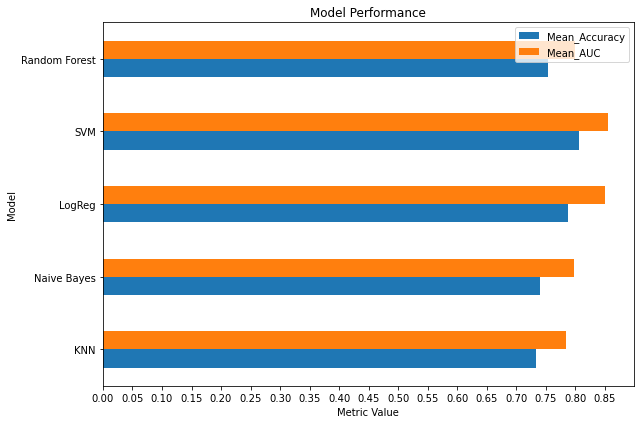

In [29]:
# Plot the performance of each model against the Accuracy & AUC metrics
model_performance[['Mean_Accuracy', 'Mean_AUC']].plot(figsize=(9, 6), kind='barh', xticks=np.arange(0, 0.9, 0.05))

format_plot(title='Model Performance', xlabel='Metric Value', ylabel='Model')

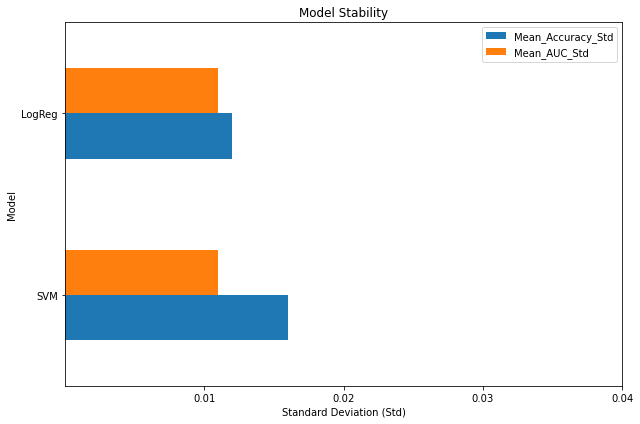

In [30]:
# Plot the stability of our top model choices by evaluating Accuracy & AUC standard deviations
model_performance.loc[['SVM', 'LogReg'], ['Mean_Accuracy_Std', 'Mean_AUC_Std']].plot(
    figsize=(9, 6), kind='barh', xticks=np.arange(0.01, 0.05, 0.01)
)

format_plot(title='Model Stability', xlabel='Standard Deviation (Std)', ylabel='Model')

# Model Evaluation

The distribution of the predicted upsets across the tournament rounds in our test set is very similar to the true target variable values we observed in our original dataset, with the primary differences being fewer first round upsets and more third round (Sweet 16) upsets than expected. The upsets by seed pairing also shows strong similarities to our original dataset's trends.

The confusion matrix at the end of this section allows us to see how this model performs in relation to precision (false positives; type I error) and recall (false negatives; type II error). Interestingly, the only metric that appears to be subpar is the recall for predicting an upset (when Underdog_Upset == 1). This suggests our model could be a little conversative and not pick upsets when it actually should, so that's important to keep in mind as we transition into making predictions for this year's March Madness matchups.

In [31]:
# Identify best model to use, then make predictions with said model
best_model = cv_models['LogReg'][-1].best_estimator_
y_preds = best_model.predict(prep_X_test)

display(best_model)

LogisticRegression(C=1, random_state=42)

In [32]:
# Concatenate all visualization data into a single DataFrame
test_game_data = pd.concat([y_test, all_rounds, mm_matchups_df[['Seed_Favorite', 'Seed_Underdog']]], 
                           join='inner', axis=1).drop('Underdog_Upset', axis=1)
# Overwrite the actual target variable (used for the join) with the model's predictions
test_game_data['Underdog_Upset'] = y_preds

# Get seed pairs data
test_seed_pairs = get_seed_pairs(test_game_data)
# Extract seed pairs that resulted in upsets
test_upset_pairs = test_seed_pairs[test_seed_pairs['Underdog_Upset'] == 1]

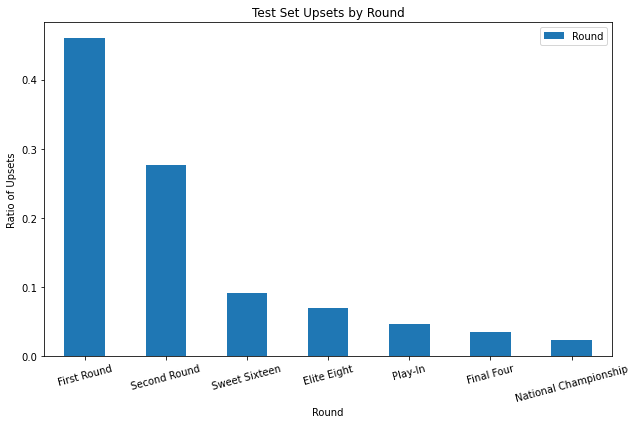

In [33]:
# Group upset seed pairs by round and count them
test_upset_rounds_freq = test_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
test_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Test Set Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

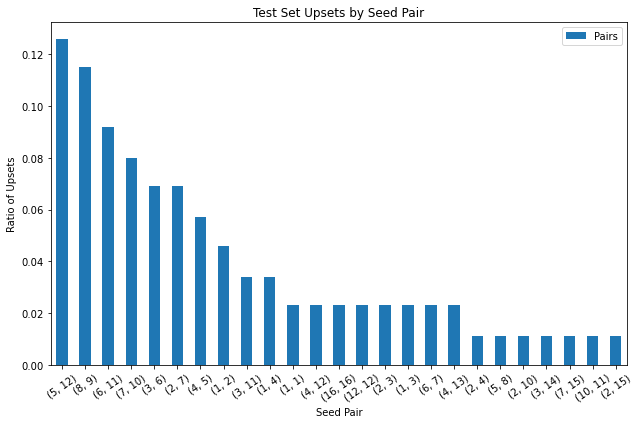

In [34]:
# Group upsets by seed pairing and count them
test_upset_pairs_freq = np.round(test_upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

# Plot findings
test_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Test Set Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

In [35]:
# Show confusion matrix for model's predictions
report = get_classification_report(y_test, y_preds)
print("Test Set Metrics Report \n\n", report)

Test Set Metrics Report 

               precision    recall  f1-score   support

           0       0.83      0.91      0.87       240
           1       0.76      0.60      0.67       110

    accuracy                           0.81       350
   macro avg       0.80      0.76      0.77       350
weighted avg       0.81      0.81      0.81       350



# 2021 March Madness Predictions

## Data Pipeline

We first scrape ESPN for the starting matchups in the play-in and the first round. We then automate the prediction of all rounds in the March Madness bracket. In short, the winners predicted from the first round (filled with predicted play-in winners) are reformatted to create matchups for the second round. Those second round winners are then reformatted into the third round, and so on and so forth until a champion is crowned.

Should you be curious about the more intricate details, you may refer to the bracket_pipeline() custom API documentation.

In [36]:
# Check if the starting bracket CSV exists, if it doesn't then create it
try:
    curr_bracket_df = pd.read_csv(f'{curr_year}_march_madness_curr_start_bracket.csv')
except FileNotFoundError:
    curr_bracket_df = fetch.get_current_bracket('http://www.espn.com/mens-college-basketball/tournament/bracket')
    curr_bracket_df.to_csv(f'{curr_year}_march_madness_curr_start_bracket.csv', index=False)

# Extract play-in matchups
play_in = curr_bracket_df[:4]
play_in = play_in.reindex([0, 1, 3, 2])

# Extract first round matchups
first_round = curr_bracket_df[4:]
first_round.index = range(len(first_round))

display(play_in), display(first_round)

,Seed,Team,Seed.1,Team.1
0,16,Norfolk St,16,Appalachian State
1,11,Wichita State,11,Drake
3,16,Mount St. Mary's,16,Texas Southern
2,11,Michigan State,11,UCLA


,Seed,Team,Seed.1,Team.1
0,1,Gonzaga,16,NaN
1,8,Oklahoma,9,Missouri
2,5,Creighton,12,UC Santa Barbara
3,4,Virginia,13,Ohio
4,6,USC,11,NaN
5,3,Kansas,14,Eastern Washington
6,7,Oregon,10,VCU
7,2,Iowa,15,Grand Canyon
8,1,Michigan,16,NaN
9,8,LSU,9,St. Bonaventure


(None, None)

In [37]:
# Create DataFrame with all March Madness predictions
bracket_preds = bracket_pipeline(curr_year, play_in, first_round, best_model, fit_df, null_drops)
display(bracket_preds)

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,Norfolk St,16,Appalachian State,Play-In,1,Appalachian State
1,11,Drake,11,Wichita State,Play-In,0,Drake
2,16,Texas Southern,16,Mount St. Mary's,Play-In,0,Texas Southern
3,11,UCLA,11,Michigan State,Play-In,0,UCLA
4,1,Gonzaga,16,Appalachian State,First Round,0,Gonzaga
...,...,...,...,...,...,...,...
62,3,Arkansas,9,Wisconsin,Elite Eight,1,Wisconsin
63,2,Houston,12,Oregon State,Elite Eight,1,Oregon State
64,2,Alabama,6,USC,Final Four,1,USC
65,9,Wisconsin,12,Oregon State,Final Four,1,Oregon State


## Pre-Tournament Model Evaluation (3/17/21)

The distribution of the upsets across the tournament rounds generated by our bracket_pipeline() is very similar to what we observed in our test set, so we need to be mindful of being too conversative with upset predictions in the first round and being too aggressive in the second and third rounds. This aggression is seen in some upset seed pairings such as (3, 11), (1, 12), and (2, 12).

Nonetheless, it was very encouraging to see our model predict exactly 20 upsets for the entire tournament. This is right on par with our dataset's historical mean.

In [38]:
# Display bracket_pipeline() predictions by round
for _round in bracket_preds['Round'].unique():
    display(bracket_preds[bracket_preds['Round'] == _round])

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,Norfolk St,16,Appalachian State,Play-In,1,Appalachian State
1,11,Drake,11,Wichita State,Play-In,0,Drake
2,16,Texas Southern,16,Mount St. Mary's,Play-In,0,Texas Southern
3,11,UCLA,11,Michigan State,Play-In,0,UCLA


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
4,1,Gonzaga,16,Appalachian State,First Round,0,Gonzaga
5,8,Oklahoma,9,Missouri,First Round,1,Missouri
6,5,Creighton,12,UC Santa Barbara,First Round,0,Creighton
7,4,Virginia,13,Ohio,First Round,0,Virginia
8,6,USC,11,Drake,First Round,0,USC
9,3,Kansas,14,Eastern Washington,First Round,0,Kansas
10,7,Oregon,10,VCU,First Round,0,Oregon
11,2,Iowa,15,Grand Canyon,First Round,0,Iowa
12,1,Michigan,16,Texas Southern,First Round,0,Michigan
13,8,LSU,9,St. Bonaventure,First Round,0,LSU


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
36,1,Gonzaga,9,Missouri,Second Round,0,Gonzaga
37,4,Virginia,5,Creighton,Second Round,1,Creighton
38,3,Kansas,6,USC,Second Round,1,USC
39,2,Iowa,7,Oregon,Second Round,1,Oregon
40,1,Michigan,8,LSU,Second Round,1,LSU
41,5,Colorado,13,UNC Greensboro,Second Round,0,Colorado
42,3,Texas,11,UCLA,Second Round,1,UCLA
43,2,Alabama,10,Maryland,Second Round,0,Alabama
44,1,Baylor,9,Wisconsin,Second Round,1,Wisconsin
45,4,Purdue,5,Villanova,Second Round,0,Purdue


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
52,1,Gonzaga,5,Creighton,Sweet Sixteen,0,Gonzaga
53,6,USC,7,Oregon,Sweet Sixteen,0,USC
54,5,Colorado,8,LSU,Sweet Sixteen,0,Colorado
55,2,Alabama,11,UCLA,Sweet Sixteen,0,Alabama
56,4,Purdue,9,Wisconsin,Sweet Sixteen,1,Wisconsin
57,2,Ohio State,3,Arkansas,Sweet Sixteen,1,Arkansas
58,1,Illinois,12,Oregon State,Sweet Sixteen,1,Oregon State
59,2,Houston,14,Morehead State,Sweet Sixteen,0,Houston


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
60,1,Gonzaga,6,USC,Elite Eight,1,USC
61,2,Alabama,5,Colorado,Elite Eight,0,Alabama
62,3,Arkansas,9,Wisconsin,Elite Eight,1,Wisconsin
63,2,Houston,12,Oregon State,Elite Eight,1,Oregon State


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
64,2,Alabama,6,USC,Final Four,1,USC
65,9,Wisconsin,12,Oregon State,Final Four,1,Oregon State


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
66,6,USC,12,Oregon State,National Championship,0,USC


In [39]:
# Get seed pairs data
curr_seed_pairs = get_seed_pairs(bracket_preds)
# Extract seed pairs that resulted in upsets
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

Total Upsets: 25


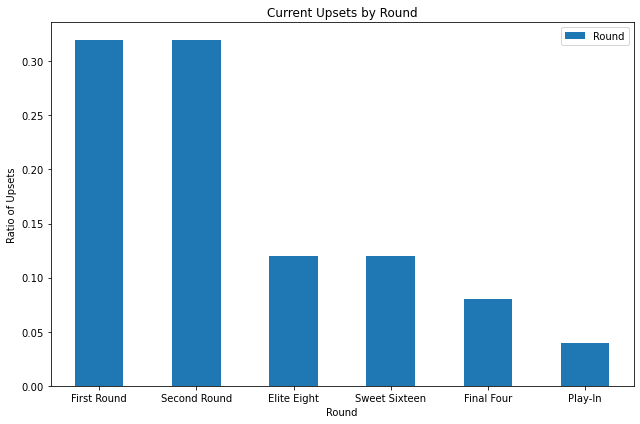

In [40]:
# Group upset seed pairs by round and count them
curr_upset_rounds_freq = curr_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
curr_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='Current Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')
print(f"Total Upsets: {len(curr_upset_pairs)}")

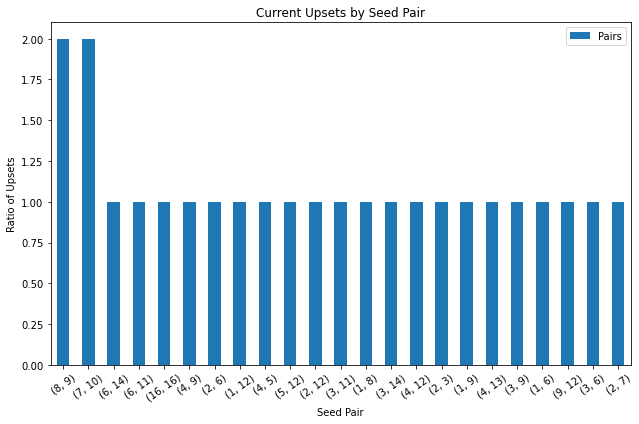

In [41]:
# Group upsets by seed pairing and count them
curr_upset_pairs_freq = curr_upset_pairs['Pairs'].value_counts()

# Plot findings
curr_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Current Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

## Post-Tournament Model Evaluation

# Conclusion & Future Work